<a href="https://colab.research.google.com/github/soycong/2021_DL_Exercise/blob/main/Ex5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[실습05] 합성곱 신경망(2)
휴먼지능정보공학과 201910805 백서희

[Github URL] https://github.com/soycong

#1. Settings
1) Important required libraries
2) Hyperparameter

In [1]:
#!unzip '/content/drive/MyDrive/DL_EX5/baking+utils'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import utils

batch_size=16 #64 #1
learning_rate=0.0001
epoch=20

n_node=1024 #customized last layer의 노드의 수 64, 128, 256 ,512, 1024
dropratio=0.5 #얼마나 드랍시킬지 inverse keepratio

imgsize=256

#2. Data Loader

In [3]:
#data loader
img_dir="baking/train"
train_data=dset.ImageFolder(img_dir, transforms.Compose([
                            transforms.CenterCrop(imgsize*2), #CenterCrop(512)
                            transforms.RandomCrop(imgsize), #RandomCrop
                            transforms.RandomHorizontalFlip(), #RandomHorizontalFlip
                            transforms.Resize(imgsize),transforms.ToTensor()]))

print(train_data.__len__())

train_batch=data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

46


고정된 데이터셋

In [4]:
img_dir="baking/val"
dev_data=dset.ImageFolder(img_dir, transforms.Compose([transforms.CenterCrop(size=imgsize), transforms.RandomCrop(imgsize),transforms.ToTensor()]))

dev_batch=data.DataLoader(dev_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
img_dir="baking/test"
test_data=dset.ImageFolder(img_dir, transforms.Compose([transforms.CenterCrop(size=imgsize), transforms.RandomCrop(imgsize),transforms.ToTensor()]))

test_batch=data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
nclass=len(train_data.classes)
print("# of classes: %d"%nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test:%d" %(train_data.__len__(),dev_data.__len__(),test_data.__len__()))

# for imgs, labels in train_batch:
#   for j in range(len(imgs)):
#     img=transforms.ToPILImage()(img[j])
#     plt.title("label: %d" %labels[i])
#     plt.imshow(img)
#     plt.show()


# of classes: 2
['cookies', 'muffins']
{'cookies': 0, 'muffins': 1}
46
Training: 46, Dev: 17, Test:37


In [7]:
#.ipynb_checkpoints가 클래스로 출력되는 경우 새로운 폴더에 train, test, val을 만들어 옮겨야함
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cookies', 'muffins']
['cookies', 'muffins']
['cookies', 'muffins']


#3. Model


In [8]:
#Model

#Pretrained VGG Model
vgg=models.vgg19(pretrained=True)

for name, module in vgg.named_children():
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

print(list(vgg.children())[0][0])

#Customized Fully Model
base_dim=64
fsize=int(imgsize/32)

class MyVGG(nn.Module):
  def __init__(self):
    super(MyVGG, self).__init__()
    #[0]:features(conv), [1]:classifier(fc)
    self.layer0=nn.Sequential(*list(vgg.children())[0])

    self.layer1=nn.Sequential(
        nn.Linear(8*base_dim*fsize*fsize, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, nclass)
    )

    for m in self.layer1.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight.data)
            m.bias.data.fill_(0)
        if isinstance(m, nn.Linear):
            init.kaiming_normal(m.weight.data)
            m.bias.data.fill_(0)
    
  def forward(self,x):
      #print(x.size()) #layer0의 사이즈를 프린트하여 확인 가능 (batchsize,x,x,x)
      out=self.layer0(x)
      out=out.view(out.size(0),-1)
      out=self.layer1(out)
      return out

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [9]:
#Model on GPU
model=MyVGG().cuda()

for params in model.layer0.parameters():
  params.required_grad=False

for params in model.layer1.parameters():
  params.required_grad=True

for name in model.children():
  print(name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

#4. Optimizer & Loss

In [10]:
#optimizer & loss
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.layer1.parameters(), lr=learning_rate)

#5. Train

In [11]:
import utils

total_time=0
disp_step=10

to_train=True
if(to_train==False):
  netname='/content/drive/MyDrive/DL_EX5/muffincookie_vgg19_10.pkl'
  model=torch.load(netname)

else:
  print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
  model.eval()
  train_corr=utils.ComputeCorr(train_batch, model)
  dev_corr=utils.ComputeCorr(dev_batch, model)
  test_corr=utils.ComputeCorr(test_batch, model)
  print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
  model.train()

  netname='/content/drive/MyDrive/DL_EX5/muffincookie_vgg19'

  #graph 그리기
  x_epoch=[]
  y_train_err=[]
  y_dev_err=[]
  y_test_err=[]

  x_epoch.append(0)
  y_train_err.append(100.0-train_corr)
  y_dev_err.append(100.0-dev_corr)
  y_test_err.append(100.0-test_corr)

  #학습 재시작
  # netname='../nets/media_pre_vgg19.pkl'
  # model=torch.load(netname)

  # for params in model.layer0.parameters():
  #   params.required_grad=False

  # for params in model.layer1.parameters():
  #   params.required_grad=True

  # for i in range(34, epoch):

  #재시작하지 않는다면
  for i in range(epoch):
    start_time=time.time()
    print("%d.." %i),
    for img, label in train_batch:
      img=Variable(img).cuda()
      label=Variable(label).cuda()

      optimizer.zero_grad()
      output=model(img)
      loss=loss_func(output,label)
      loss.backward()
      optimizer.step()

    end_time=time.time()
    duration=end_time-start_time
    total_time+=duration

    if(i%disp_step==0) or (i==epoch-1):
      torch.save(model, netname+'_%d.pkl'%i,)
      print("\n[%d/%d] loss: %.3f, " %(i,epoch,(loss.cpu()).data.numpy())),

      model.eval()

      train_corr=utils.ComputeCorr(train_batch, model)
      dev_corr=utils.ComputeCorr(dev_batch, model)
      test_corr=utils.ComputeCorr(test_batch, model)
      print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
      model.train()
      print("time: %.2f sec.." %(total_time))

      x_epoch.append(i+1)
      y_train_err.append(100.0-train_corr)
      y_dev_err.append(100.0-dev_corr)
      y_test_err.append(100.0-test_corr)
  print("Total time:%.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 45.65, dev: 41.18, test: 51.35
0..

[0/20] loss: 1.122, 
Correct of train: 54.35, dev: 41.18, test: 54.05
time: 0.86 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.857, 
Correct of train: 93.48, dev: 82.35, test: 78.38
time: 9.84 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.784, 
Correct of train: 91.30, dev: 88.24, test: 81.08
time: 17.97 sec..
Total time:17.97 sec


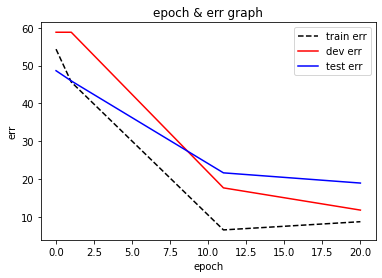

In [12]:
#epoch-err curve
if(to_train):
  plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
  plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
  plt.plot(x_epoch, y_test_err, color='blue', label='test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc='upper right')
  plt.show()

#6. Evaluation for dev & test data

Normalized confusion matrix


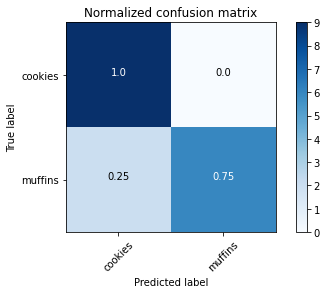

Confusion matrix, without normalization


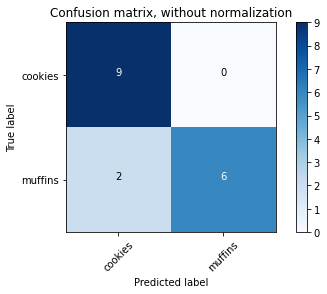

	 acc  |	 pre  |	 rec  |	 f1
 cookies: 0.88 |	 0.82 |	 1.00 |	 0.90
 muffins: 0.88 |	 1.00 |	 0.75 |	 0.86
*accuracy: 0.88, precision: 0.91, recall: 0.88, *f1 score: 0.88
[AP]
cookies: 0.91
muffins: 0.95

[mAP] 0.926
[miAP] 0.941


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.7878629 , 0.91562998, 0.70796984, 0.7820853 , 0.67211181,
        0.92360687, 0.63171506, 0.90359461, 0.82092935, 0.86903787,
        0.51588088, 0.73254597, 0.98456484, 0.87676257, 0.96961385,
        0.84134132, 0.59198976]))

In [13]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


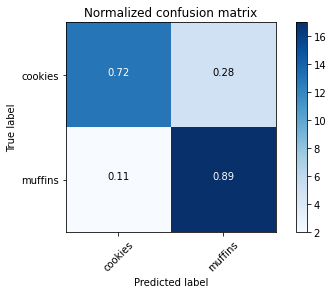

Confusion matrix, without normalization


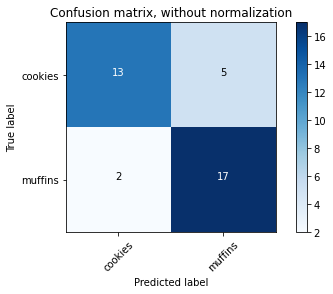

	 acc  |	 pre  |	 rec  |	 f1
 cookies: 0.81 |	 0.87 |	 0.72 |	 0.79
 muffins: 0.81 |	 0.77 |	 0.89 |	 0.83
*accuracy: 0.81, precision: 0.82, recall: 0.81, *f1 score: 0.81
[AP]
cookies: 0.92
muffins: 0.88

[mAP] 0.902
[miAP] 0.905


In [14]:
model.eval()
_,_,_=utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: cookies
 True predicted images/total cookies category: 9 / 9
Predicted probability:
[0.7878629  0.21213709]


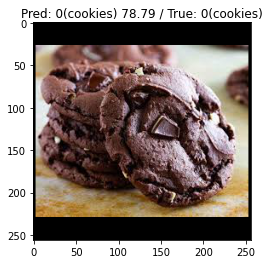

Predicted probability:
[0.91563    0.08437001]


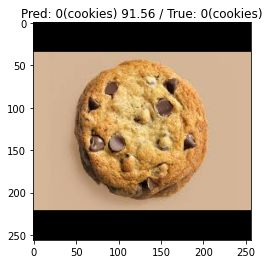

 False predicted images/total cookies category: 0 / 9
Category: muffins
 True predicted images/total muffins category: 6 / 8
Predicted probability:
[0.1309621  0.86903787]


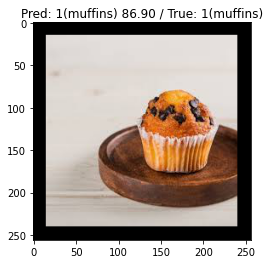

Predicted probability:
[0.26745403 0.732546  ]


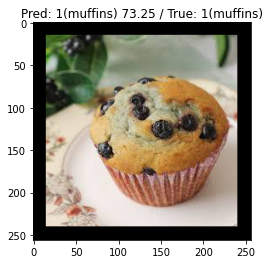

 False predicted images/total muffins category: 2 / 8
Predicted probability:
[0.5158809  0.48411912]


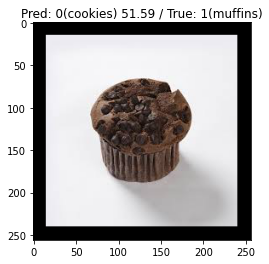

Predicted probability:
[0.8413413  0.15865871]


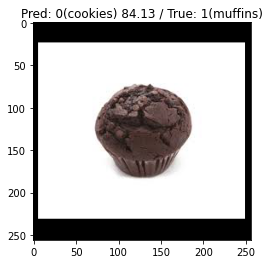

In [15]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)